In [1]:
import json
from tqdm import tqdm
import k3d
import numpy as np
from matplotlib import pyplot as plt

In [2]:
with open('/scratches/octopus_2/fml35/datasets/scannet/scan2cad_annotations/full_annotations.json','r') as f:
    annotations = json.load(f)

In [3]:
print(len(annotations))

1506


In [4]:
def get_top8_classes_scannet():                                                                                                                                                                                                                                                                                           
    top = {}
    top["03211117"] = "display"
    top["04379243"] = "table"
    top["02808440"] = "bathtub"
    top["02747177"] = "bin"
    top["04256520"] = "sofa"
    top["03001627"] = "chair"
    top["02933112"] = "cabinet"
    top["02871439"] = "bookshelf"
    top["02818832"] = "bed"
    return top

cat_id_to_label = get_top8_classes_scannet()

In [5]:
with open('/scratches/octopus_2/fml35/datasets/scannet/data_splits/scannetv2_train.txt','r') as f:
    train = f.readlines()
train_scenes = [x.strip() for x in train]

with open('/scratches/octopus_2/fml35/datasets/scannet/data_splits/scannetv2_val.txt','r') as f:
    val = f.readlines()
val_scenes = [x.strip() for x in val]

In [20]:
print(annotations[0])

data = {}
data["train"] = {}
data["val"] = {}
for kind in data:
    data[kind]['scale'] = []
    data[kind]['bbox'] = []
    data[kind]['center'] = []
    data[kind]['category'] = []
    data[kind]['model_id'] = []
    data[kind]['sym'] = []

for i in tqdm(range(len(annotations))):
    scene = annotations[i]['id_scan']
    kind = None
    if scene in train_scenes:
        kind = 'train'
    elif scene in val_scenes:
        kind = 'val'

    for j in range(len(annotations[i]['aligned_models'])):
        catid = annotations[i]['aligned_models'][j]['catid_cad']
        if catid in cat_id_to_label:
            data[kind]['scale'].append(annotations[i]['aligned_models'][j]['trs']['scale'])
            data[kind]['bbox'].append(annotations[i]['aligned_models'][j]['bbox'])
            data[kind]['center'].append(annotations[i]['aligned_models'][j]['center'])
            data[kind]['sym'].append(annotations[i]['aligned_models'][j]['sym'])
            data[kind]['model_id'].append(annotations[i]['aligned_models'][j]['id_cad'])
            data[kind]['category'].append(cat_id_to_label[catid])
    

    

{'trs': {'translation': [-2.0622268696315587, -1.1547378823161127, 4.003703072667122], 'rotation': [-0.7071067811865476, 0.7071067811865475, -0.0, -0.0], 'scale': [1.0, 1.0, 1.0]}, 'n_aligned_models': 6, 'aligned_models': [{'trs': {'translation': [-1.3907626831793112, -0.739014773954928, -0.8651410504703799], 'rotation': [-0.6516910613244714, -0.025038890957017487, 0.7578385578484266, -0.018775909236155224], 'scale': [2.5978772385754834, 2.193563434058858, 2.2005665277932556]}, 'bbox': [0.4406924843788147, 0.15240350365638733, 0.18045249581336975], 'center': [-0.0034175068140029907, 0.003734499216079712, -0.03349149972200394], 'sym': '__SYM_NONE', 'id_cad': 'e877f5881c54551a2665f68ebc337f05', 'catid_cad': '04256520', 'keypoints_cad': {'n_keypoints': 10, 'position': [-1.0665689706802368, -0.6007881760597229, 0.22967366874217987, -1.613540768623352, -0.7790815234184265, 0.07669646292924881, -0.9986969232559204, -0.7431813478469849, -0.4816667139530182, -0.9227705597877502, -0.73517632484

100%|██████████| 1506/1506 [00:00<00:00, 21166.03it/s]


In [21]:
for kind in data:
    for key in data[kind]:
        data[kind][key] = np.array(data[kind][key])
        assert len(data[kind][key]) == len(data[kind]['category'])

In [22]:
print(data['train']['scale'].shape)
print(data['train']['bbox'].shape)

for key in data['train']:
    print(key)

(9894, 3)
(9894, 3)
scale
bbox
center
category
model_id
sym


In [29]:
train_scale_by_model_id  = {}
for i in range(len(data['train']['scale'])):
    model_id = data['train']['model_id'][i]
    if model_id not in train_scale_by_model_id:
        train_scale_by_model_id[model_id] = []
    train_scale_by_model_id[model_id].append(data['train']['scale'][i])

for key in train_scale_by_model_id:
    train_scale_by_model_id[key] = np.array(train_scale_by_model_id[key])

median_scale_by_model_id = {}
for key in train_scale_by_model_id:
    median_scale_by_model_id[key] = np.median(train_scale_by_model_id[key],axis=0)




N_in_train = 0
N_offset_correct = 0
print("len(data['val']['scale'])",len(data['val']['scale']))
for i in range(len(data['val']['scale'])):
    scale_val = data['val']['scale'][i]
    model_id = data['val']['model_id'][i]
    if model_id in median_scale_by_model_id:
        N_in_train += 1
        scale_median_train = median_scale_by_model_id[model_id]
        offset_s = np.mean(np.abs(scale_val / scale_median_train - 1))
        if offset_s < 0.2:
            N_offset_correct += 1

print('N_in_train ',N_in_train)
print('N_offset_correct ',N_offset_correct)



# print(len(train_scale_by_model_id))
# counter = 0
# for key in train_scale_by_model_id:
#     print(key, len(train_scale_by_model_id[key]),train_scale_by_model_id[key])
#     counter += 1
#     if counter == 5:
#         break

# all_lengths = []
# for key in train_scale_by_model_id:
#     all_lengths.append(len(train_scale_by_model_id[key]))

# print('mean lenght', np.mean(all_lengths))
# print('median lenght', np.median(all_lengths))


len(data['val']['scale']) 2844
N_in_train  2332
N_offset_correct  1778


In [9]:
cats =list(set(data['train']['category']))
for cat in cats[:3]:
    print(cat)
    plot = k3d.plot(camera_auto_fit=False)

    cat_mask = data['train']['category'] == cat
    scale = data['train']['scale'][cat_mask] * data['train']['bbox'][cat_mask] * 2

    mask_around_1 = (scale > 0.8).all(axis=1) & (scale < 1.2).all(axis=1)
    print(np.sum(mask_around_1) ,'out of', len(scale))

    plot += k3d.points(scale,color=(0 + 255 * 256 + 255 * 256 * 256),point_size=0.05, shader="flat")
    plot += k3d.points(scale[mask_around_1],color=(0 + 0 * 256 + 255 * 256 * 256),point_size=0.05, shader="flat")

    plot.display()

table
18 out of 2063


/scratch/fml35/environments/shape_env_octo/lib/python3.6/site-packages/traittypes/traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))


Output()

display
0 out of 579


Output()

bathtub
0 out of 354


Output()

In [10]:
def find_limits(data):
    sorted = np.sort(data)
    outliers_removed = sorted[int(0.005*len(sorted)):int(0.995*len(sorted))]
    return (np.min(outliers_removed),np.max(outliers_removed))



def create_limits(data,cats):

    axis_names = ['x','y','z']
    limits = {}
    for cat in cats:
        limits[cat] = {}

        cat_mask_train = data['train']['category'] == cat
        scale_normalised_train = data['train']['scale'][cat_mask_train] * data['train']['bbox'][cat_mask_train] * 2

        min_all = []
        max_all = []
        mode_all = []
        for i in range(3):
            min_axis,max_axis = find_limits(scale_normalised_train[:,i])
            hist,bin_edges = np.histogram(scale_normalised_train[:,i], bins=100)
            max_bin = np.argmax(hist)
            mode = np.mean([bin_edges[max_bin],bin_edges[max_bin+1]])

            min_all.append(min_axis)
            max_all.append(max_axis)
            mode_all.append(mode)

        limits[cat]['min'] = min_all
        limits[cat]['max'] = max_all
        limits[cat]['mode'] = mode_all
    return limits

def show_dist_category(data,category,show_raw=False):
    cat_mask_train = data['train']['category'] == cat
    cat_mask_val = data['val']['category'] == cat

    scale_train = data['train']['scale'][cat_mask_train]
    scale_normalised_train = data['train']['scale'][cat_mask_train] * data['train']['bbox'][cat_mask_train] * 2

    scale_val = data['val']['scale'][cat_mask_val]
    scale_normalised_val = data['val']['scale'][cat_mask_val] * data['val']['bbox'][cat_mask_val] * 2

    print('min x',np.min(scale_normalised_train[:,0]))
    print('max x',np.max(scale_normalised_train[:,0]))
    print(find_limits(scale_normalised_train[:,0]))
    hist,bin_edges = np.histogram(scale_normalised_train[:,0], bins=100)
    mode = np.argmax(hist)
    print('bin edges',bin_edges[mode],bin_edges[mode+1])

    list_data = [scale_normalised_train,scale_normalised_val]
    list_labels = ["norm train","norm val"]
    if show_raw:
        list_data = [scale_train,scale_val] + list_data
        list_labels = ["raw train","raw val"] + list_labels

    visualise_dists(list_data,list_labels,title=category)

def visualise_dists(list_data,list_labels,title=''):
    assert len(list_data) == len(list_labels)
    fig = plt.figure(figsize=(16, 5))
    plt.axis('off')
    plt.grid(b=None)   
    plt.title(title)
    for i in range(3):
        ax = fig.add_subplot(1, 3,i+1)
        for k in range(len(list_data)):
            ax.hist(list_data[k][:,i],bins=100,label=list_labels[k])
        ax.legend()
    plt.show()

def show_dist_model(data,model_id):
    model_mask_train = data['train']['model_id'] == model_id
    model_mask_val = data['val']['model_id'] == model_id

    scale_normalised_train = data['train']['scale'][model_mask_train] * data['train']['bbox'][model_mask_train] * 2
    scale_normalised_val = data['val']['scale'][model_mask_val] * data['val']['bbox'][model_mask_val] * 2
    print(scale_normalised_train)
    print(scale_normalised_val)

    list_data = [scale_normalised_train,scale_normalised_val]
    list_labels = ["norm train","norm val"]
    # list_data = [scale_normalised_train]
    # list_labels = ["norm train"]
    visualise_dists(list_data,list_labels,title=model_id)



e877f5881c54551a2665f68ebc337f05
[[2.28972995 0.66861351 0.79419544]
 [2.09523653 0.90650627 0.86698306]]
[]


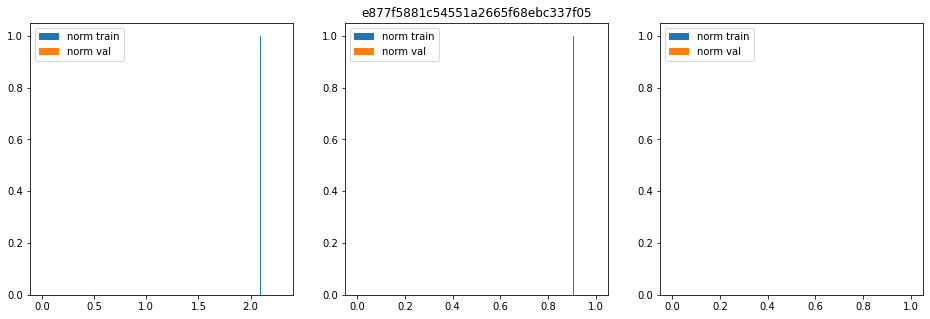

267dcf5952e84873fad6a32f56e259a2
[[0.82419979 0.74179209 0.73441561]]
[]


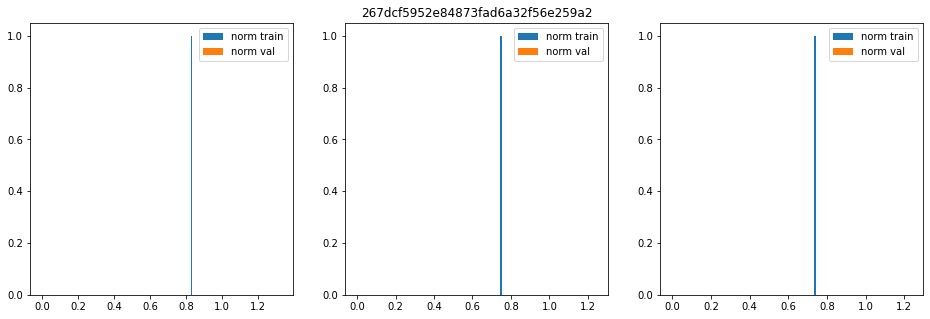

918ae8afec3dc70af7628281ecb18112
[[0.82891534 0.80331848 0.97538538]
 [0.8765609  0.7887213  0.96539517]]
[]


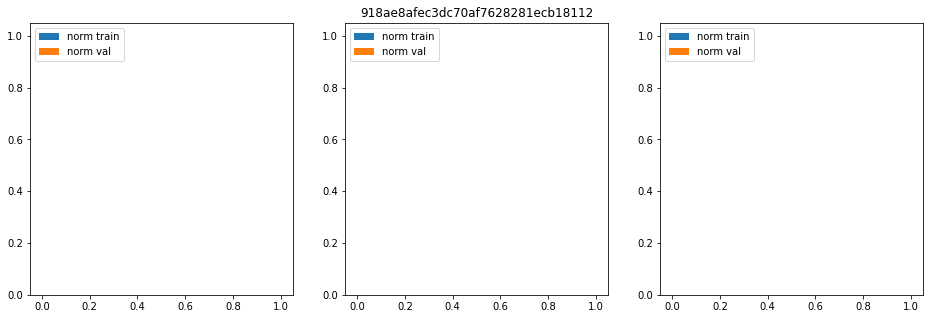

918ae8afec3dc70af7628281ecb18112
[[0.82891534 0.80331848 0.97538538]
 [0.8765609  0.7887213  0.96539517]]
[]


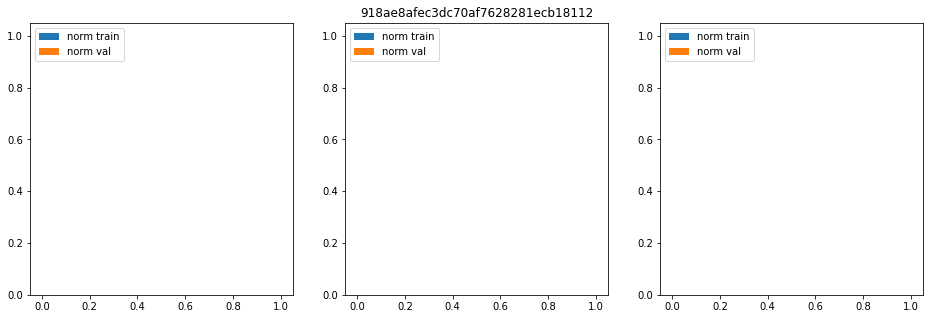

3c899eb5c23784f9febad4f49b26ec52
[[0.78301796 0.37345181 0.60217439]
 [0.80024804 0.37002581 0.59904054]
 [0.93579267 0.34442008 0.93289122]
 [0.50916025 0.43363891 0.44577207]
 [0.7481899  0.45037985 0.74325369]
 [0.983926   0.40807274 0.90248063]
 [0.93298817 0.377331   0.93231748]
 [0.68537554 0.56911736 0.82057255]
 [0.74672516 0.59710462 0.76977741]
 [0.88293274 0.37492479 0.84486276]
 [0.63548969 0.39097283 0.62890694]
 [0.62298271 0.40659689 0.60874889]]
[]


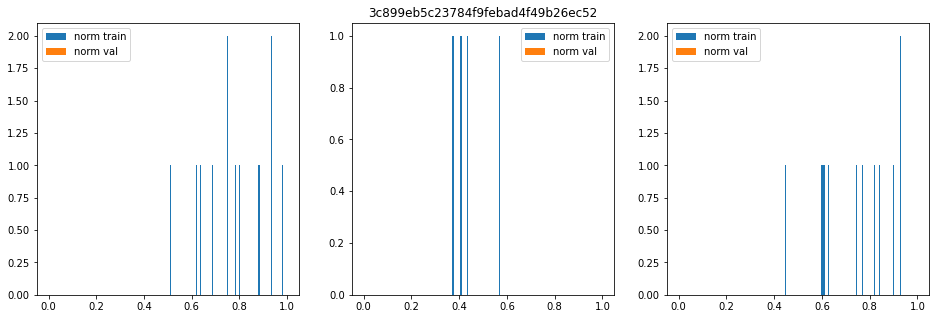

3c899eb5c23784f9febad4f49b26ec52
[[0.78301796 0.37345181 0.60217439]
 [0.80024804 0.37002581 0.59904054]
 [0.93579267 0.34442008 0.93289122]
 [0.50916025 0.43363891 0.44577207]
 [0.7481899  0.45037985 0.74325369]
 [0.983926   0.40807274 0.90248063]
 [0.93298817 0.377331   0.93231748]
 [0.68537554 0.56911736 0.82057255]
 [0.74672516 0.59710462 0.76977741]
 [0.88293274 0.37492479 0.84486276]
 [0.63548969 0.39097283 0.62890694]
 [0.62298271 0.40659689 0.60874889]]
[]


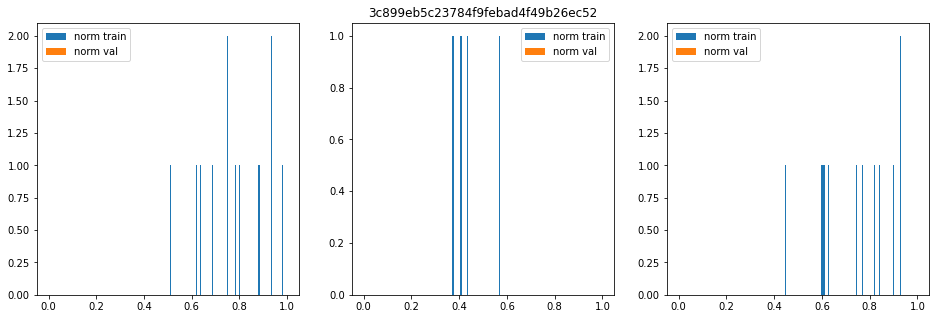

75dbeb01fdc7f265d0a96520c31993ad
[[0.35227544 0.31717378 0.22761139]
 [0.38105533 0.35966648 0.34714486]
 [0.37530624 0.27922544 0.22304656]
 [0.24351542 0.29038957 0.30144227]]
[]


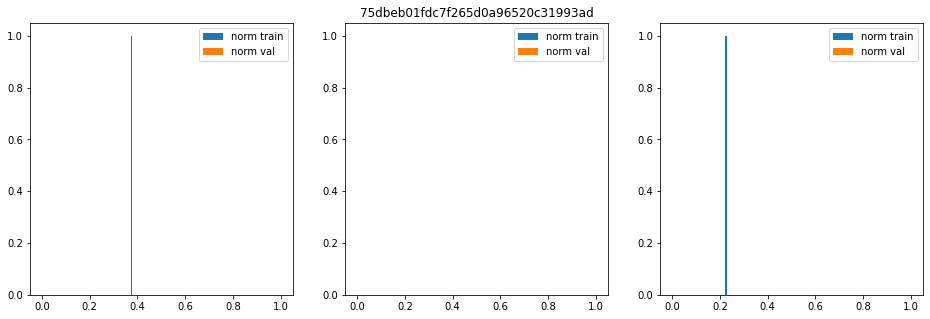

38773e1ff9871cb33321831d2245cf06
[[0.50003916 0.53486968 0.51646801]
 [0.54674984 0.14541106 0.41209292]
 [0.53988803 0.28606402 0.49934866]
 [0.72761213 0.36362016 0.43043015]
 [0.44832488 0.28008424 0.32845332]
 [0.52403476 0.2095583  0.396053  ]
 [0.42737534 0.24525996 0.30163539]
 [0.45297283 0.24781777 0.30800749]
 [0.45659464 0.18623356 0.32587992]
 [0.45731835 0.23544472 0.31674404]
 [0.45451957 0.10717313 0.4993373 ]
 [0.47681109 0.12073973 0.4849487 ]
 [0.45799103 0.11580186 0.49437073]
 [0.50858121 0.11700738 0.41649407]
 [0.58540465 0.18409134 0.42669921]
 [0.42188698 0.17163576 0.35048805]
 [0.42938237 0.17903184 0.35008686]
 [0.52628164 0.14388864 0.37132615]
 [0.61502969 0.1885551  0.41811921]
 [0.59746162 0.16797508 0.37192562]
 [0.45208438 0.21011673 0.30016617]
 [0.36432387 0.15755227 0.39125303]]
[[0.57722536 0.22745959 0.37107049]
 [0.52846802 0.22633662 0.45079379]
 [0.55680683 0.12140705 0.44951366]
 [0.54885927 0.22241037 0.4014306 ]
 [0.59690948 0.20961211 0.4670

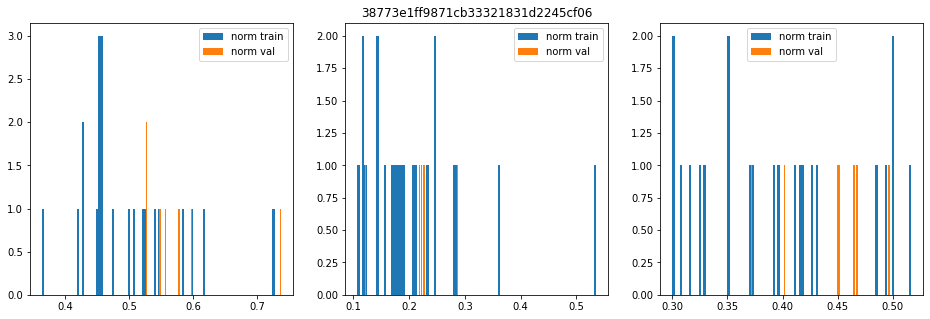

14a49c2b9f46faa04d6ef9ab90177563
[[0.25694061 0.30694052 0.21918212]
 [0.25131657 0.31434329 0.24846098]
 [0.18057979 0.22056254 0.22127655]
 [0.32109916 0.21748112 0.26110336]
 [0.26873325 0.32168571 0.25693904]
 [0.2930698  0.32138813 0.25339578]
 [0.29913575 0.35953532 0.28548137]
 [0.34093122 0.86251453 0.32356756]
 [0.39451725 0.84381379 0.34991563]
 [0.54375758 0.66892156 0.50179168]
 [0.51142635 0.67874459 0.55701163]
 [0.49548499 0.68647622 0.50844328]
 [0.54132229 0.65356124 0.54060635]
 [0.55741963 0.66339121 0.54605941]
 [0.56527937 0.68406967 0.54194491]
 [0.55564371 0.66240951 0.53060564]
 [0.35138098 0.33037275 0.33068573]
 [0.26541082 0.33484073 0.27531616]
 [0.27554994 0.22151823 0.2956999 ]
 [0.27304376 0.33374143 0.28503304]
 [0.29165279 0.23359336 0.29452561]
 [0.29381972 0.24935891 0.29580697]]
[[0.16954699 0.19020474 0.17680336]
 [0.25229932 0.31365052 0.24992092]]


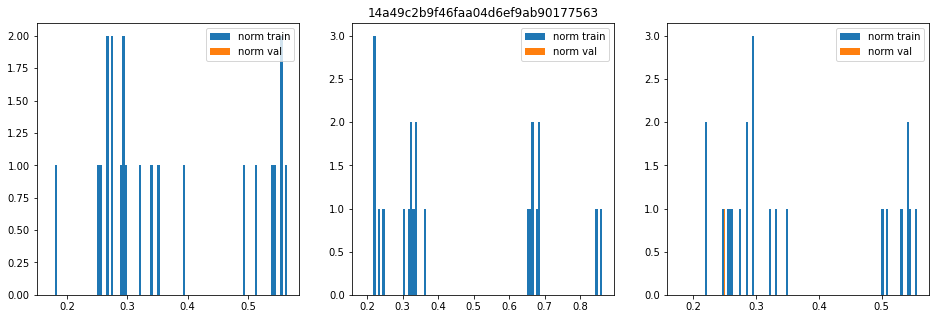

e0229fb0e8d85e1fbfd790572919a77f
[[2.81719993e+00 7.30504874e-01 2.61576330e+00]
 [1.66965365e+00 6.89900598e-01 7.67785000e-01]
 [1.59215995e+00 7.13929882e-01 7.16060370e-01]
 [1.62733744e+00 6.91161870e-01 7.80911540e-01]
 [1.55958518e+00 5.63028981e-01 8.17864030e-01]
 [5.11232092e-01 4.93812847e-01 3.79356313e-01]
 [4.03216266e+00 7.10015357e-01 1.36318040e+00]
 [1.87972346e+00 7.37366550e-01 8.65292736e-01]
 [2.87015074e+00 9.17018393e-01 8.06409946e-01]
 [6.75301789e-01 7.90619459e-01 5.70205345e-01]
 [1.03868927e+00 7.00904964e-01 6.00450761e-01]
 [1.26387810e+00 7.16087025e-01 7.94874328e-01]
 [1.38344800e+00 8.67436501e-01 1.03446836e+00]
 [2.01007768e+00 7.41607814e-01 1.33586319e+00]
 [6.95035632e-01 4.82316123e-01 6.18358298e-01]
 [9.89618414e-01 7.23216380e-01 5.70734215e-01]
 [1.13837905e+00 6.88899099e-01 7.95236116e-01]
 [1.09382014e+00 7.24850420e-01 7.23407165e-01]
 [9.69321501e-01 7.08484660e-01 7.23595591e-01]
 [1.26257825e+00 7.62166583e-01 7.05135544e-01]
 [9.340

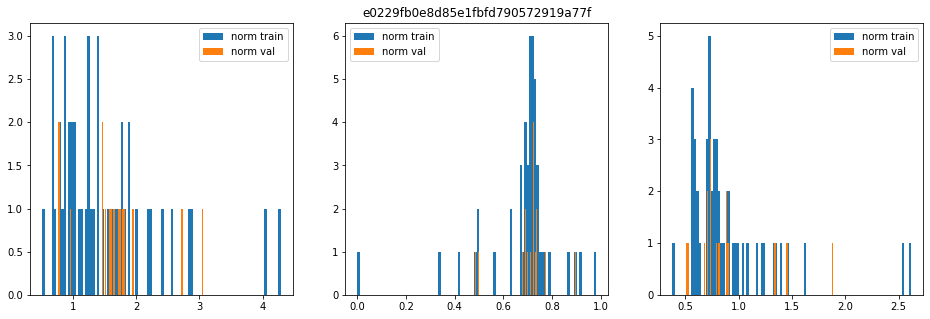

In [11]:
for id in data['train']['model_id'][:10]:
    print(id)
    show_dist_model(data,id)

# show_dist_model(data,'e877f5881c54551a2665f68ebc337f05')

min x 0.24423816229745568
max x 11.533050157853024
(0.3109414213765283, 3.845323205074835)
bin edges 1.147343121941901 1.2602312418974566


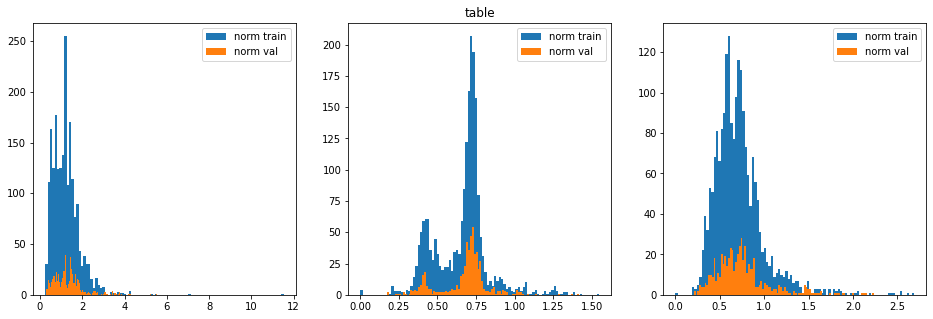

min x 0.2515942942669746
max x 2.2953635648848616
(0.27126714341340913, 1.4615507112178547)
bin edges 0.496846606741121 0.5172842994472999


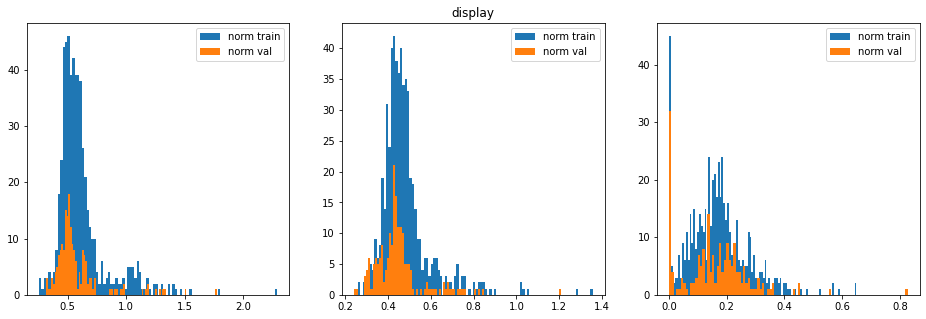

min x 0.27698673946001046
max x 1.860124013660815
(0.31489536154699976, 1.722217064650905)
bin edges 0.5777828215581633 0.5936141943001714


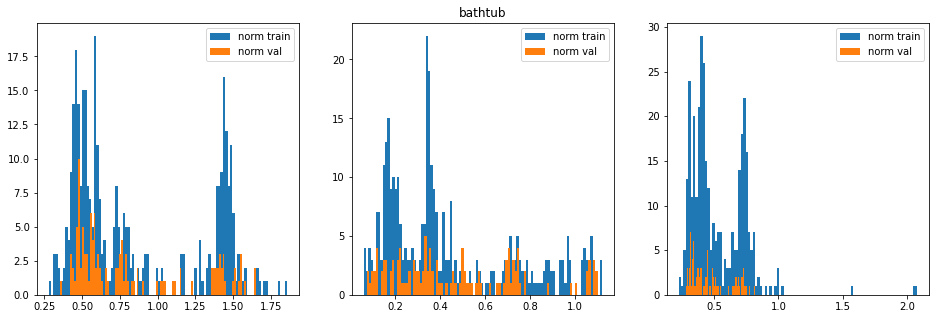

min x 0.2559057848653161
max x 6.470621633304028
(0.2937274840698509, 3.3228371748339973)
bin edges 0.7530830527404131 0.8152302112248002


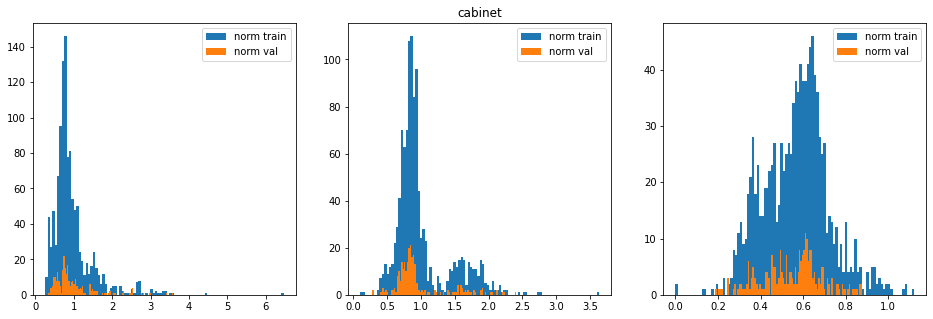

min x 0.1432774258695468
max x 1.0879820290453397
(0.16803654805701856, 0.705874161056738)
bin edges 0.29443016237767367 0.30387720840943155


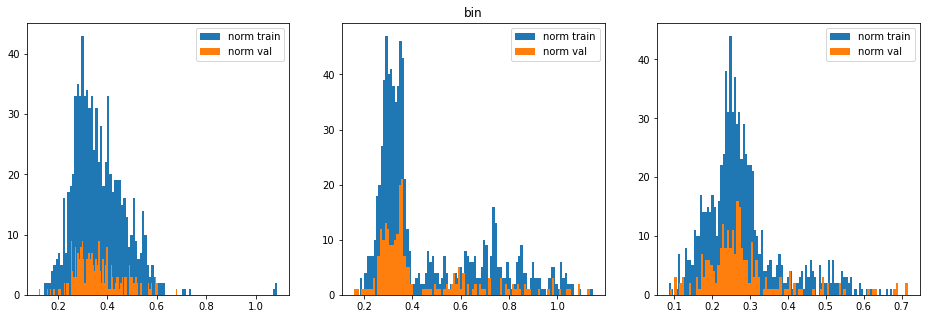

min x 0.3070253386493335
max x 2.187298825082714
(0.33461787956760064, 2.075893955413834)
bin edges 1.604414044288366 1.6232167791527


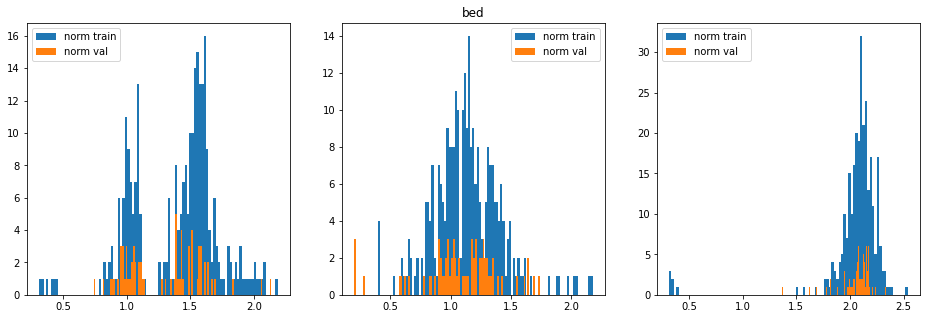

min x 0.26094768646524996
max x 1.3271359114657673
(0.3275652086187002, 0.9611182355215137)
bin edges 0.46352344921534827 0.4741853314653534


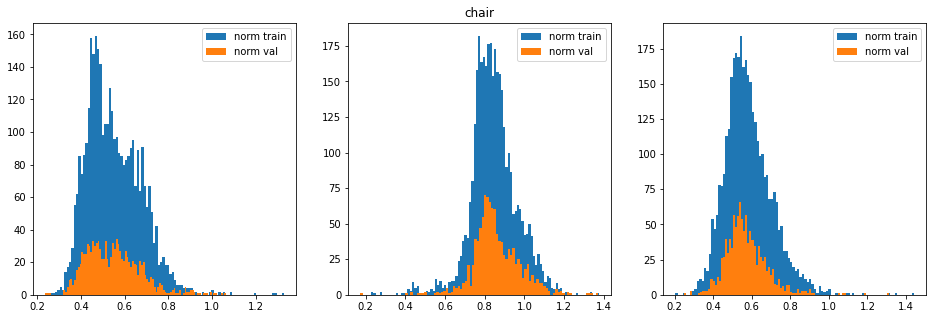

min x 0.24158460262068332
max x 5.262105535883863
(0.3053747694413813, 3.8394034575586717)
bin edges 0.7436366959470013 0.793841905279633


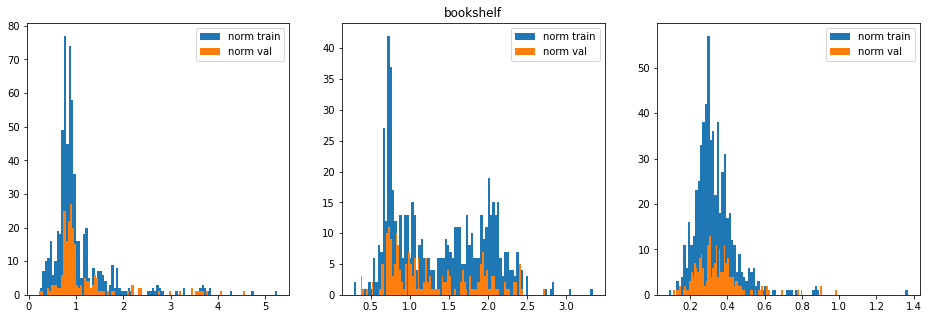

min x 0.39821496614882834
max x 4.200739528951063
(0.48788569794775777, 3.349637467665936)
bin edges 2.071325773781812 2.109351019409834


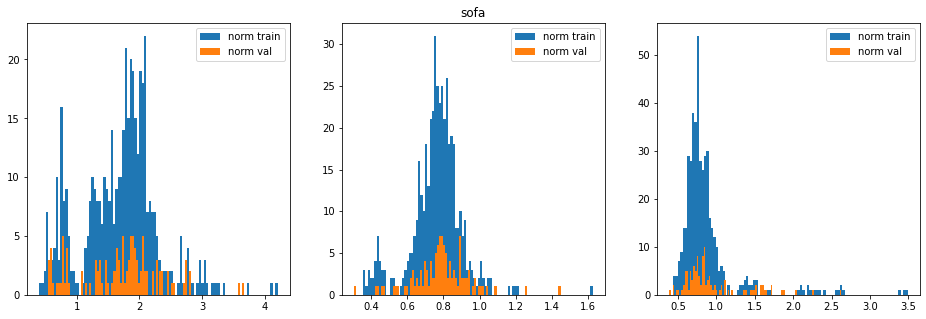

In [12]:
for cat in cats:
    show_dist_category(data,cat)


In [13]:
limits = create_limits(data,cats)

with open('/scratch2/fml35/datasets/own_data/data_leveraging_geometry_for_shape/data_01/scaling_limits.json','w') as f:
    json.dump(limits,f,indent=4)
print(limits)

{'table': {'min': [0.3109414213765283, 0.20660846107572398, 0.25724239760489126], 'max': [3.845323205074835, 1.2718733524191264, 2.011651040825181], 'mode': [1.2037871819196788, 0.7186470521401489, 0.6046684168645362]}, 'display': {'min': [0.27126714341340913, 0.2858335644629269, 3.1443538095165095e-15], 'max': [1.4615507112178547, 1.0379733414727312, 0.5704092909354608], 'mode': [0.5070654530942105, 0.429640384783125, 0.0032484404680800474]}, 'bathtub': {'min': [0.31489536154699976, 0.06385706857716716, 0.2348677970321674], 'max': [1.722217064650905, 1.1106208810113953, 1.5688143576376863], 'mode': [0.5856985079291673, 0.340142963673746, 0.40078665612964315]}, 'cabinet': {'min': [0.2937274840698509, 0.396385563654385, 0.19620662107877085], 'max': [3.3228371748339973, 2.287646885437283, 0.9997379827206728], 'mode': [0.7841566319826067, 0.8618413886388832, 0.6447324960521958]}, 'bin': {'min': [0.16803654805701856, 0.20180137828307762, 0.11113436842373764], 'max': [0.705874161056738, 1.0

In [14]:
# check if model_ids unique
import os
ids = []
dir = '/scratches/octopus_2/fml35/datasets/shapenet_v2/ShapeNetRenamed/model'
for cat in os.listdir(dir):
    for model_id in os.listdir(os.path.join(dir,cat)):
        ids.append(model_id)

assert len(ids) == len(set(ids))
print(len(ids))

2589


In [15]:
models_train = set(data["train"]["model_id"])
models_val = set(data["val"]["model_id"])

print('len train',len(models_train))
print('len val',len(models_val))
print(len(models_train - models_val))
print(len(models_val- models_train))

len train 2283
len val 848
1741
306


9894
2844


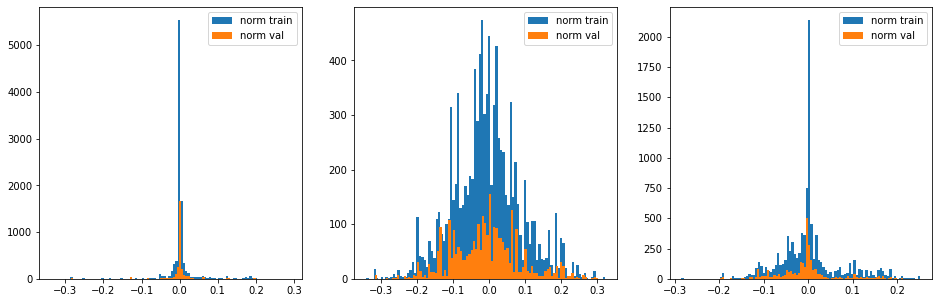

In [16]:

mask_sym_train = data['train']['sym'] != '__SYM_NONE_dfd'
mask_sym_val = data['val']['sym'] != '__SYM_NONE_dfd'
# __SYM_NONE
# __SYM_ROTATE_UP_4

# scale_train = data['train']['scale'][cat_mask_train]
# scale_normalised_train = data['train']['scale'][cat_mask_train] * data['train']['bbox'][cat_mask_train] * 2

# scale_val = data['val']['scale'][cat_mask_val]
# scale_normalised_val = data['val']['scale'][cat_mask_val] * data['val']['bbox'][cat_mask_val] * 2


list_data = [data['train']['center'][mask_sym_train],data['val']['center'][mask_sym_val]]
list_labels = ["norm train","norm val"]
print(len(data['train']['center'][mask_sym_train]))
print(len(data['val']['center'][mask_sym_val]))

visualise_dists(list_data,list_labels,title='')

In [17]:
for i in range(len(data["train"]['sym'])):
    if data["train"]['sym'][i] == '__SYM_ROTATE_UP_4' and data["train"]['center'][i][0] > 0.15:
        print(data["train"]['model_id'][i])
        print(data['train']['category'][i])

c26913f8e139a80baa2b654345545ea
table
c26913f8e139a80baa2b654345545ea
table
c26913f8e139a80baa2b654345545ea
table
c26913f8e139a80baa2b654345545ea
table
c26913f8e139a80baa2b654345545ea
table
c26913f8e139a80baa2b654345545ea
table
c26913f8e139a80baa2b654345545ea
table
c26913f8e139a80baa2b654345545ea
table
c26913f8e139a80baa2b654345545ea
table
c26913f8e139a80baa2b654345545ea
table
c26913f8e139a80baa2b654345545ea
table
c26913f8e139a80baa2b654345545ea
table
c26913f8e139a80baa2b654345545ea
table
c26913f8e139a80baa2b654345545ea
table
c26913f8e139a80baa2b654345545ea
table
c26913f8e139a80baa2b654345545ea
table
c26913f8e139a80baa2b654345545ea
table
c26913f8e139a80baa2b654345545ea
table
c26913f8e139a80baa2b654345545ea
table
c26913f8e139a80baa2b654345545ea
table
c26913f8e139a80baa2b654345545ea
table
c26913f8e139a80baa2b654345545ea
table
c26913f8e139a80baa2b654345545ea
table
